# JupyterLab beyond simple widgets: interactive Lorentzian fitting

> JupyterLab can be interactive with IPython widgets. But we can also make the plot interactive and act like a GUI app!

In [1]:
import json
from pathlib import Path

import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

PWD = Path(".")
data_file = PWD / "data" / "2_1.dat"

## What's interactive Lorentzian fitting?

If you ever tried to fit the curves like below with a set of Lorentzian functions
$$
y(x)=\sum_{i=0}^{N-1}\frac{A_{i}}{\pi}\frac{\sigma_{i}}{(x-\mu_{i})^{2}+\sigma_{i}^{2}}+C
$$
you will know the importance of a good initial guess of the parameters. If you don't know about it, the task here is to find the best $A_i$, $\mu_i$, $\sigma_i$ and $C$ with the given experimental data, where $\mu$ is the center of the peak, $\sigma$ is a parameter specifying the width, $A$ is a parameter specifying the amplitude, and $C$ is a constant background. Since there are so many parameters and the curve can be quite different with different sets of parameters, it's hard to do the fitting without a sensible initial guess.

In [2]:
def read_table(data_file):
    return pd.read_table(
        data_file,
        encoding="ISO-8859-1",
        delimiter=r"\s+",
        skiprows=6,
        names=["x", "y"],
    )

<AxesSubplot:xlabel='x'>

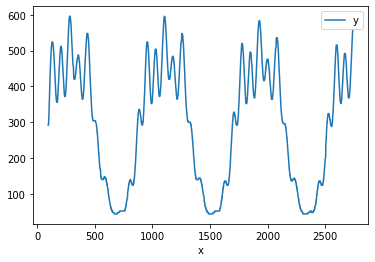

In [3]:
read_table(data_file).plot("x", "y")

How to provide an initial guess? The most straightforward way is to guess reasonable $\sigma_0 = \sigma_i$, and the centers and heights of the peaks for $\mu_i$ and $A_i$. Other peaks can affect the center and height of the peak so it is a rough approximation, but enough in this case.

How to find the peaks, then? Of course one can use the peak finding algorithm, but I had some bad times to tune the parameters of the peak finding function, and I don't like to hard-code the parameters. Instead, I'm going to provide the peaks manually. But again, no hard-code parameters, so copying all the coordinates into the code is not a desirable solution. I'd like to provide the peaks by interactively clicking on the plots.

## Interactive JupyterLab plots

![JupyterLab with sliders](https://jupyterlab.readthedocs.io/en/stable/_images/jupyterlab.png)

Typical interactive Jupyter notebooks involves some buttons, sliders, and inputs, as the image above shows. But the examples haven't leveraged the power of Matplotlib. Matplotlib not only supports simple widgets like the sliders, but also supports mouse clicks and many more events.

In this example, the button is provided by IPython, and the mouse events are handled by Matplotlib via [`ipympl`](https://matplotlib.org/ipympl/). `ipympl` enables the interactive features of Matplotlib in Jupyter by passing the events to a live Python kernel.

`ipympl` is easy to install:

```sh
pip install ipympl
```

And to enable it, just use `%matplotlib ipympl` magic in the notebook.

In [4]:
%matplotlib ipympl

## Click and update

The basic example of handling mouse events is to add a scatter point on mouse click.

In [5]:
def click_and_update(figname):
    plt.close(figname)  # close the figure when rerun the cell
    fig = plt.figure(figname)
    ax = fig.subplots()
    points = []
    scatter_plot = ax.scatter([], [], marker="x")

    def onclick(event):
        if event.button == 1:  # LEFT
            points.append([event.xdata, event.ydata])
        xdata, ydata = zip(*points)
        scatter_plot.set_offsets(np.c_[xdata, ydata])
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("button_press_event", onclick)
    plt.show()

In the `onclick` function, we first add the point to a list called `points`, and then update the scatter with `set_offsets`, and finally update the canvas with `fig.canvas.draw_idle`. We then connect the handler `onclick` with the `button_press_event` event. The final result should look like this:

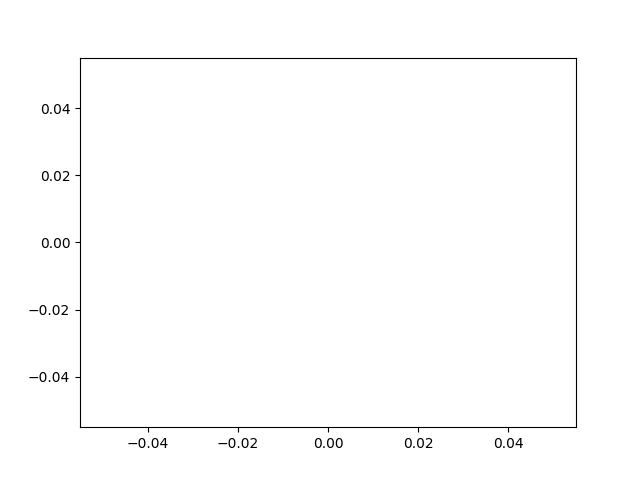

In [6]:
click_and_update("click_example")

The exceptions raised and lines printed in the `on_click` handler will not show up in the notebook. Instead, you can find the detailed logs in the log panel. If you can't find the button for the log panel in the status line, you can choose "View -> Activate Command Palette" in the menu and select "Show Log Console" to bring it up.

## Click on the peaks and save them

With the basic knowledge of Matplotlib event handling in JupyterLab, we can now start build the blocks for interactive fitting. The first step is to click on the peaks and save them.

In [7]:
def fit_data_peaks_incomplete(data_file: Path, name: str):
    df = read_table(data_file)
    peak_file = PWD / "peaks" / f"{name}.json"
    result_file = PWD / "results" / f"{name}.json"

    plt.close(name)
    fig = plt.figure(name)
    ax = fig.subplots()
    ax.plot(df.x, df.y, label="Data")

    peak_scatter = None

    if not result_file.exists():
        if peak_file.exists():
            peaks = json.loads(peak_file.read_text())
            peak_scatter = ax.scatter(*zip(*peaks), marker="+")
        else:
            print("Peak file not found")
            peaks = []
            peak_scatter = ax.scatter([], [], marker="+")

        action_button = widgets.Button(
            description=f"Fit {len(peaks)} peaks", button_style="success"
        )

    def onclick(event):
        if event.button == 1:  # LEFT
            peaks.append([event.xdata, event.ydata])
        elif event.button == 3:  # RIGHT
            idmin = np.linalg.norm(
                np.array(peaks) - np.array([event.xdata, event.ydata]), axis=-1
            ).argmin()
            peaks.pop(idmin)
        else:
            return
        action_button.description = f"Fit {len(peaks)} peaks"
        xdata, ydata = zip(*peaks)
        peak_scatter.set_offsets(np.c_[xdata, ydata])
        fig.canvas.draw_idle()

    def do_fit(event):
        del event  # unused
        peak_file.write_text(json.dumps(peaks, indent=2))
        print("To be implemented")

    if result_file.exists():
        fit_result = load_modelresult(result_file)
        plot_fit(fit_result)
        results[name] = fit_result
    else:
        fig.canvas.mpl_connect("button_press_event", onclick)
        action_button.on_click(do_fit)
        display(action_button)

    plt.show()

Here we define a function called `fit_data_peaks`. It first calls the `read_table` function with parses the data and returns a `DataFrame` with two columns, `x` and `y`. Then the data is plotted. Next, if the results haven't been stored, we go to the peak-clicking mode (the final `else` clause), where the `on_click` function handles the most of the logic, which is similar to the previous example. One additional functionality is that when right clicked, the peak point nearest to the cursor is removed, which can be quite useful. When the button is clicked, we are supposed to the the curve fitting and save the results, but in this example we just save the clicked peaks.

Peak file not found


Button(button_style='success', description='Fit 0 peaks', style=ButtonStyle())

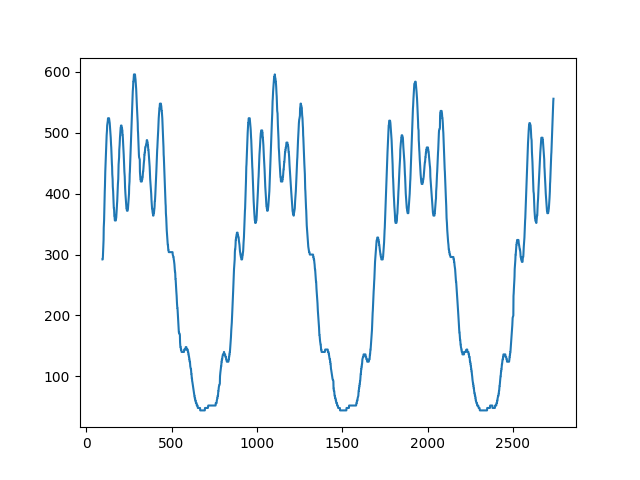

In [8]:
fit_data_peaks_incomplete(data_file, "show clicks")

## Fitting the curve

I use the [lmfit](https://github.com/lmfit/lmfit-py) module for curve fitting, and use the [uncertainties](https://github.com/lebigot/uncertainties) module for easy calculating the uncertainties.

In [9]:
from lmfit.model import load_modelresult, save_modelresult
from lmfit.models import ConstantModel, LinearModel, LorentzianModel
from lmfit.parameter import Parameters

In [10]:
def fit_data_peaks(data_file: Path, name: str):
    df = read_table(data_file)
    peak_file = PWD / "peaks" / f"{name}.json"
    result_file = PWD / "results" / f"{name}.json"

    plt.close(name)
    fig = plt.figure(name)
    ax = fig.subplots()
    ax.plot(df.x, df.y, label="Data")

    peak_scatter = None

    if not result_file.exists():
        if peak_file.exists():
            peaks = json.loads(peak_file.read_text())
            peak_scatter = ax.scatter(*zip(*peaks), marker="+")
        else:
            print("Peak file not found")
            peaks = []
            peak_scatter = ax.scatter([], [], marker="+")

        action_button = widgets.Button(
            description=f"Fit {len(peaks)} peaks", button_style="success"
        )

    def onclick(event):
        if event.button == 1:  # LEFT
            peaks.append([event.xdata, event.ydata])
        elif event.button == 3:  # RIGHT
            idmin = np.linalg.norm(
                np.array(peaks) - np.array([event.xdata, event.ydata]), axis=-1
            ).argmin()
            peaks.pop(idmin)
        else:
            return
        action_button.description = f"Fit {len(peaks)} peaks"
        xdata, ydata = zip(*peaks)
        peak_scatter.set_offsets(np.c_[xdata, ydata])
        fig.canvas.draw_idle()

    def do_fit(event):
        del event  # unused
        action_button.disabled = True
        peak_file.write_text(json.dumps(peaks, indent=2))
        gmodel = ConstantModel()
        for i in range(len(peaks)):
            gmodel += LorentzianModel(prefix=f"p{i}_")
        params = gmodel.make_params(c=0)
        init_sigma = 30
        for i, peak in enumerate(peaks):
            params[f"p{i}_center"].value = peak[0]
            params[f"p{i}_amplitude"].value = peak[1] * np.pi * init_sigma
            params[f"p{i}_sigma"].value = init_sigma
        fit_result = gmodel.fit(df.y, params, x=df.x)

        results[name] = fit_result

        save_modelresult(fit_result, result_file)

        plot_fit(fit_result)

    def plot_fit(fit_result):
        if peak_scatter is not None:
            peak_scatter.remove()
        ax.plot(df.x, fit_result.best_fit, label="Fit")
        ax.legend()
        fig.canvas.draw_idle()
        fig.savefig(
            PWD / "images" / f"{name}.pdf",
            dpi=150,
            transparent=True,
            metadata={"CreationDate": None},
            bbox_inches="tight",
        )

    if result_file.exists():
        fit_result = load_modelresult(result_file)
        plot_fit(fit_result)
        results[name] = fit_result
    else:
        fig.canvas.mpl_connect("button_press_event", onclick)
        action_button.on_click(do_fit)
        display(action_button)

    plt.show()

In the `do_fit` function, a model is created according to the number of peaks, and is fitted against the data using the `fit` method. Then the result is saved to a global variable `results` and to the `result_file` on the disk. Finally it calls the `plot_fit` function to update the figure, which removes the peaks, plots the best fit provided by lmfit, updates the plot, and saves it to a PDF file.

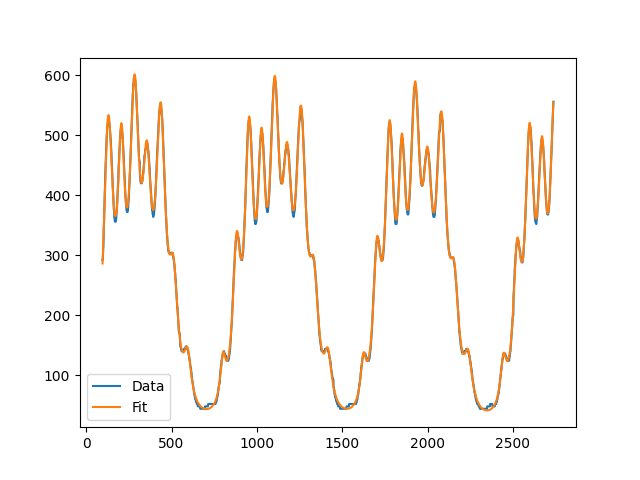

In [11]:
results = {}
fit_data_peaks(data_file, "full")